## HW3 (Mehrsa Pourya - 95101247)
## This is just Codes, PDF report is attached

# Q1

In [65]:
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('haarcascade_smile.xml')

In [71]:
def find_fes(imNum, e_sf, s_sf, s_mn, frmt):
    image = cv2.imread('TestImages/img' + str(imNum) + frmt)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
    for (x,y,w,h) in detected_faces:
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        face_region = image[y:y+h, x:x+w]
        face_region_gray = gray_image[y:y+h, x:x+w]
    detected_eyes = eye_cascade.detectMultiScale(face_region_gray, e_sf)
    eD = -1
    for (eye_x, eye_y, eye_w, eye_h) in detected_eyes:
        cv2.rectangle(face_region, (eye_x, eye_y), (eye_x + eye_w, eye_y + eye_h), (0, 255, 0), 2)
        eD = max(eD, eye_y + eye_h)
    below_eye = face_region[eD:, :]
    below_eye_gray = face_region_gray[eD:, :]
    detected_smiles = smile_cascade.detectMultiScale(below_eye_gray, s_sf, s_mn)
    for (sx,sy,sw,sh) in detected_smiles:
        cv2.rectangle(below_eye,(sx,sy),(sx+sw,sy+sh),(0,0,255),2)
    cv2.imshow('Detected Face, Eye, Smile :)',image)
    cv2.imwrite(str(imNum)+'.png',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [72]:
find_fes(1, 1.1, 3, 5, '.jpg')
find_fes(2, 1.1, 3, 5, '.jpg')
find_fes(3, 1.5, 1.5, 10, '.jpg')
find_fes(4, 3, 3, 5, '.jpg')
find_fes(5, 1.03, 1.1, 5, '.png')

# Q2

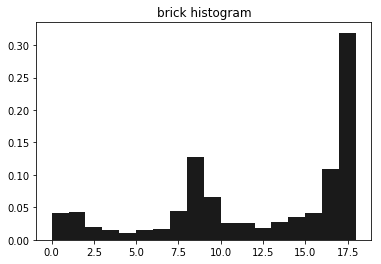

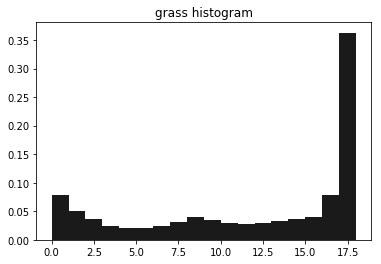

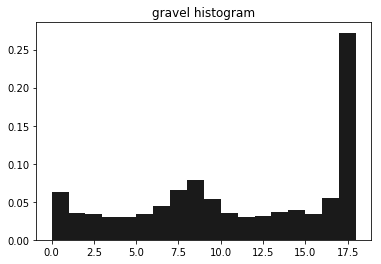

In [78]:
from skimage.feature import local_binary_pattern
from skimage import data
import numpy as np
from matplotlib import pyplot as plt
brick = data.brick()
r = 2
n_p = r * 8
lbp = local_binary_pattern(brick, n_p, r, 'uniform')
n_bins = int(lbp.max() + 1)
hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.1')
plt.title('brick histogram')
plt.show()
grass = data.grass()
lbp = local_binary_pattern(grass, n_p, r, 'uniform')
n_bins = int(lbp.max() + 1)
hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.1')
plt.title('grass histogram')
plt.show()
gravel = data.gravel()
lbp = local_binary_pattern(gravel, n_p, r, 'uniform')
n_bins = int(lbp.max() + 1)
hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.1')
plt.title('gravel histogram')
plt.show()

## Q 3

In [93]:
import scipy.io              # Import scipy.io - for reading .mat file 
import numpy as np 
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.autograd import Variable

## A

In [ ]:
train = scipy.io.loadmat('train_32x32.mat')
test = scipy.io.loadmat('test_32x32.mat')

In [6]:
X_train = np.transpose(train['X'], [3, 2, 0, 1])   
y_train = train['y'] % 10
n_train = len(y_train)
X_train_vect = X_train.reshape((n_train, 32*32*3))
y_train = y_train[:,0]
X_test =  np.transpose(test['X'], [3, 2, 0, 1])
y_test = test['y'] % 10
y_test = y_test[:,0]
n_test = len(y_test)
X_test_vect = X_test.reshape((n_test, 32*32*3))
print(X_train.shape)
print(y_train.shape)
print(X_train_vect.shape)
print(X_test.shape)
print(y_test.shape)
print(X_test_vect.shape)

(73257, 3, 32, 32)
(73257,)
(73257, 3072)
(26032,)
(73257, 3, 32, 32)
(26032, 3072)


In [7]:
train_dataset = data.TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).long())
test_dataset = data.TensorDataset(torch.Tensor(X_test).float(), torch.Tensor(y_test).long())
X_train_tesnor = torch.FloatTensor(X_train_vect.tolist())
y_train_tensor = torch.LongTensor(y_train.tolist())

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

## B 

In [15]:
class CNN_Net_2L_K3(nn.Module):
    def __init__(self):
        super(CNN_Net_2L_K3, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn23 = CNN_Net_2L_K3()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn23.parameters(), lr=0.01)
acc_23_cnn = []
loss_23_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn23(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_23_cnn.append(r_loss / 100)
            acc_23_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

[epoch : 1, itr   100] loss: 1.980 acc: 0.322
[epoch : 2, itr   100] loss: 1.255 acc: 0.606
[epoch : 3, itr   100] loss: 0.929 acc: 0.720
[epoch : 4, itr   100] loss: 0.779 acc: 0.768
[epoch : 5, itr   100] loss: 0.686 acc: 0.796
[epoch : 6, itr   100] loss: 0.621 acc: 0.817
[epoch : 7, itr   100] loss: 0.582 acc: 0.830
[epoch : 8, itr   100] loss: 0.546 acc: 0.840
[epoch : 9, itr   100] loss: 0.517 acc: 0.847
[epoch : 10, itr   100] loss: 0.497 acc: 0.854
[epoch : 11, itr   100] loss: 0.475 acc: 0.860
[epoch : 12, itr   100] loss: 0.460 acc: 0.866
[epoch : 13, itr   100] loss: 0.436 acc: 0.873
[epoch : 14, itr   100] loss: 0.427 acc: 0.875
[epoch : 15, itr   100] loss: 0.405 acc: 0.881
[epoch : 16, itr   100] loss: 0.396 acc: 0.884
[epoch : 17, itr   100] loss: 0.379 acc: 0.888
[epoch : 18, itr   100] loss: 0.371 acc: 0.891
[epoch : 19, itr   100] loss: 0.363 acc: 0.894
[epoch : 20, itr   100] loss: 0.350 acc: 0.897
[epoch : 21, itr   100] loss: 0.333 acc: 0.902
[epoch : 22, itr   100

CNN 2 layers, 3x3 filters
final train accuracy :
0.90884765625


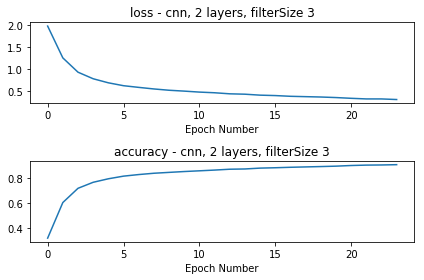

test accuracy:
0.7952135832821143
confusion matrix:


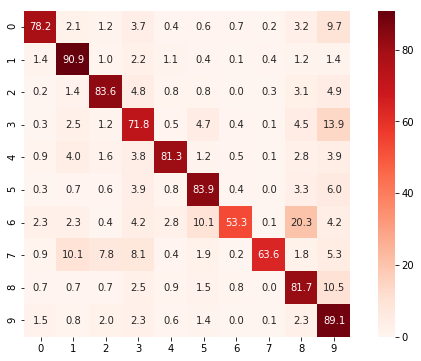

In [48]:
print('CNN 2 layers, 3x3 filters')
print('final train accuracy :')
print(acc_23_cnn[len(acc_23_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_23_cnn)
axs[0].set_title('loss - cnn, 2 layers, filterSize 3')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_23_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 2 layers, filterSize 3')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn23(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

In [50]:
class CNN_Net_2L_K5(nn.Module):
    def __init__(self):
        super(CNN_Net_2L_K5, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn25 = CNN_Net_2L_K5()

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn25.parameters(), lr=0.01)
acc_25_cnn = []
loss_25_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn25(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_25_cnn.append(r_loss / 100)
            acc_25_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

[epoch : 1, itr   100] loss: 2.280 acc: 0.202
[epoch : 2, itr   100] loss: 1.708 acc: 0.415
[epoch : 3, itr   100] loss: 1.032 acc: 0.677
[epoch : 4, itr   100] loss: 0.826 acc: 0.749
[epoch : 5, itr   100] loss: 0.727 acc: 0.781
[epoch : 6, itr   100] loss: 0.662 acc: 0.802
[epoch : 7, itr   100] loss: 0.614 acc: 0.816
[epoch : 8, itr   100] loss: 0.568 acc: 0.830
[epoch : 9, itr   100] loss: 0.538 acc: 0.840
[epoch : 10, itr   100] loss: 0.511 acc: 0.847
[epoch : 11, itr   100] loss: 0.471 acc: 0.860
[epoch : 12, itr   100] loss: 0.456 acc: 0.865
[epoch : 13, itr   100] loss: 0.446 acc: 0.867
[epoch : 14, itr   100] loss: 0.425 acc: 0.872
[epoch : 15, itr   100] loss: 0.408 acc: 0.878
[epoch : 16, itr   100] loss: 0.392 acc: 0.884
[epoch : 17, itr   100] loss: 0.381 acc: 0.887
[epoch : 18, itr   100] loss: 0.367 acc: 0.892
[epoch : 19, itr   100] loss: 0.357 acc: 0.894
[epoch : 20, itr   100] loss: 0.351 acc: 0.896
[epoch : 21, itr   100] loss: 0.359 acc: 0.894
[epoch : 22, itr   100

CNN 2 layers, 5x5 filters
final train accuracy :
0.8583984375


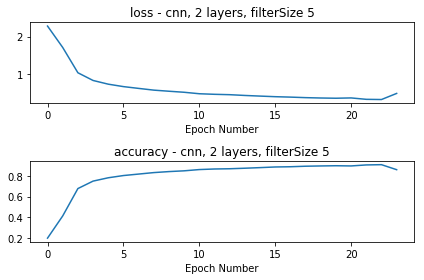

test accuracy:
0.842501536570375
confusion matrix:


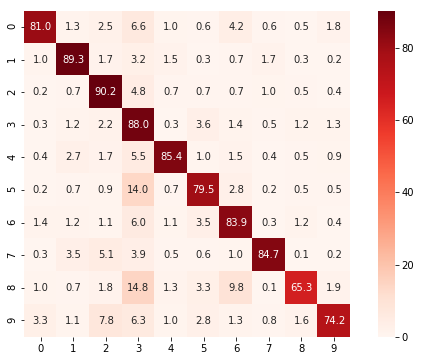

In [52]:
print('CNN 2 layers, 5x5 filters')
print('final train accuracy :')
print(acc_25_cnn[len(acc_25_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_25_cnn)
axs[0].set_title('loss - cnn, 2 layers, filterSize 5')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_25_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 2 layers, filterSize 5')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn25(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.239 acc: 0.191
[epoch : 2, itr   100] loss: 2.158 acc: 0.234
[epoch : 3, itr   100] loss: 1.908 acc: 0.350
[epoch : 4, itr   100] loss: 1.490 acc: 0.516
[epoch : 5, itr   100] loss: 1.114 acc: 0.652
[epoch : 6, itr   100] loss: 1.009 acc: 0.690
[epoch : 7, itr   100] loss: 0.800 acc: 0.758
[epoch : 8, itr   100] loss: 0.727 acc: 0.783
[epoch : 9, itr   100] loss: 0.660 acc: 0.803
[epoch : 10, itr   100] loss: 0.626 acc: 0.813
[epoch : 11, itr   100] loss: 0.607 acc: 0.820
[epoch : 12, itr   100] loss: 0.559 acc: 0.834
[epoch : 13, itr   100] loss: 0.535 acc: 0.842
[epoch : 14, itr   100] loss: 0.515 acc: 0.848
[epoch : 15, itr   100] loss: 0.504 acc: 0.851
[epoch : 16, itr   100] loss: 0.534 acc: 0.841
[epoch : 17, itr   100] loss: 0.468 acc: 0.861
[epoch : 18, itr   100] loss: 0.456 acc: 0.866
[epoch : 19, itr   100] loss: 0.442 acc: 0.870
[epoch : 20, itr   100] loss: 0.431 acc: 0.873
[epoch : 21, itr   100] loss: 0.418 acc: 0.877
[epoch : 22, itr   100

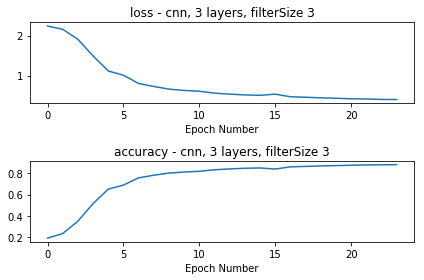

test accuracy:
0.7277965580823602
confusion matrix:


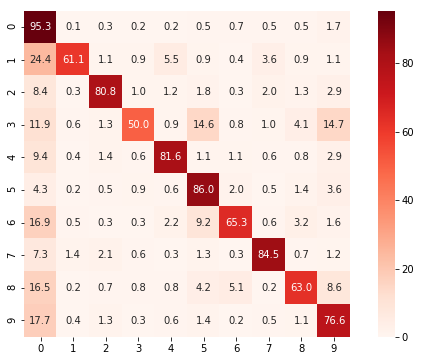

In [56]:
class CNN_Net_3L_K3(nn.Module):
    def __init__(self):
        super(CNN_Net_3L_K3, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1, stride=1)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn33 = CNN_Net_3L_K3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn33.parameters(), lr=0.01)
acc_33_cnn = []
loss_33_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn33(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_33_cnn.append(r_loss / 100)
            acc_33_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 3 layers, 3x3 filters')
print('final train accuracy :')
print(acc_33_cnn[len(acc_33_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_33_cnn)
axs[0].set_title('loss - cnn, 3 layers, filterSize 3')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_33_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 3 layers, filterSize 3')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn33(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.245 acc: 0.191
[epoch : 2, itr   100] loss: 2.058 acc: 0.294
[epoch : 3, itr   100] loss: 1.257 acc: 0.594
[epoch : 4, itr   100] loss: 0.922 acc: 0.715
[epoch : 5, itr   100] loss: 0.782 acc: 0.763
[epoch : 6, itr   100] loss: 0.709 acc: 0.786
[epoch : 7, itr   100] loss: 0.649 acc: 0.805
[epoch : 8, itr   100] loss: 0.636 acc: 0.811
[epoch : 9, itr   100] loss: 0.582 acc: 0.826
[epoch : 10, itr   100] loss: 0.548 acc: 0.837
[epoch : 11, itr   100] loss: 0.533 acc: 0.841
[epoch : 12, itr   100] loss: 0.501 acc: 0.850
[epoch : 13, itr   100] loss: 0.486 acc: 0.855
[epoch : 14, itr   100] loss: 0.468 acc: 0.859
[epoch : 15, itr   100] loss: 0.448 acc: 0.867
[epoch : 16, itr   100] loss: 0.438 acc: 0.869
[epoch : 17, itr   100] loss: 0.420 acc: 0.875
[epoch : 18, itr   100] loss: 0.421 acc: 0.874
[epoch : 19, itr   100] loss: 0.589 acc: 0.825
[epoch : 20, itr   100] loss: 0.401 acc: 0.882
[epoch : 21, itr   100] loss: 0.379 acc: 0.889
[epoch : 22, itr   100

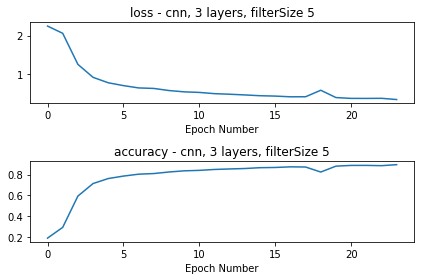

test accuracy:
0.8275968039336201
confusion matrix:


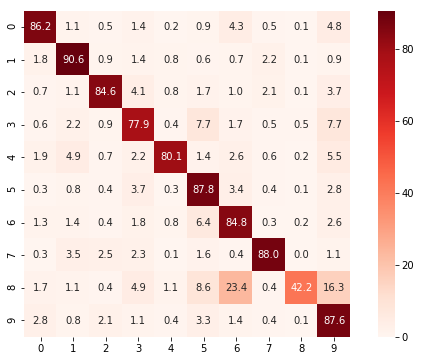

In [55]:
class CNN_Net_3L_K5(nn.Module):
    def __init__(self):
        super(CNN_Net_3L_K5, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn35 = CNN_Net_3L_K5()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn35.parameters(), lr=0.01)
acc_35_cnn = []
loss_35_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn35(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_35_cnn.append(r_loss / 100)
            acc_35_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 3 layers, 5x5 filters')
print('final train accuracy :')
print(acc_35_cnn[len(acc_35_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_35_cnn)
axs[0].set_title('loss - cnn, 3 layers, filterSize 5')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_35_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 3 layers, filterSize 5')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn35(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.242 acc: 0.188
[epoch : 2, itr   100] loss: 2.204 acc: 0.208
[epoch : 3, itr   100] loss: 2.051 acc: 0.293
[epoch : 4, itr   100] loss: 1.702 acc: 0.430
[epoch : 5, itr   100] loss: 1.290 acc: 0.580
[epoch : 6, itr   100] loss: 1.012 acc: 0.681
[epoch : 7, itr   100] loss: 0.877 acc: 0.728
[epoch : 8, itr   100] loss: 0.784 acc: 0.763
[epoch : 9, itr   100] loss: 0.707 acc: 0.786
[epoch : 10, itr   100] loss: 0.654 acc: 0.803
[epoch : 11, itr   100] loss: 0.619 acc: 0.815
[epoch : 12, itr   100] loss: 0.599 acc: 0.821
[epoch : 13, itr   100] loss: 0.700 acc: 0.793
[epoch : 14, itr   100] loss: 0.541 acc: 0.840
[epoch : 15, itr   100] loss: 0.766 acc: 0.775
[epoch : 16, itr   100] loss: 0.537 acc: 0.841
[epoch : 17, itr   100] loss: 0.512 acc: 0.848
[epoch : 18, itr   100] loss: 0.495 acc: 0.854
[epoch : 19, itr   100] loss: 0.498 acc: 0.852
[epoch : 20, itr   100] loss: 0.474 acc: 0.860
[epoch : 21, itr   100] loss: 0.454 acc: 0.865
[epoch : 22, itr   100

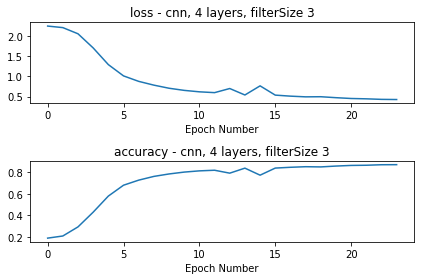

test accuracy:
0.8085049170251998
confusion matrix:


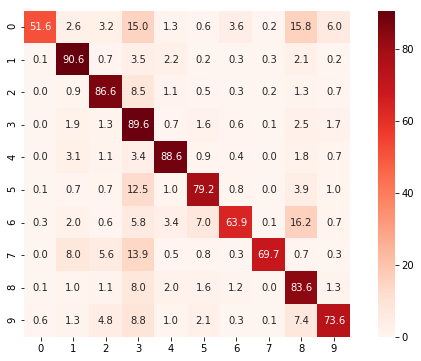

In [57]:
class CNN_Net_4L_K3(nn.Module):
    def __init__(self):
        super(CNN_Net_4L_K3, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn43 = CNN_Net_4L_K3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn43.parameters(), lr=0.01)
acc_43_cnn = []
loss_43_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn43(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_43_cnn.append(r_loss / 100)
            acc_43_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')


print('CNN 4 layers, 3x3 filters')
print('final train accuracy :')
print(acc_43_cnn[len(acc_43_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_43_cnn)
axs[0].set_title('loss - cnn, 4 layers, filterSize 3')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_43_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 4 layers, filterSize 3')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn43(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.236 acc: 0.194
[epoch : 2, itr   100] loss: 2.088 acc: 0.269
[epoch : 3, itr   100] loss: 1.657 acc: 0.453
[epoch : 4, itr   100] loss: 1.055 acc: 0.667
[epoch : 5, itr   100] loss: 0.781 acc: 0.763
[epoch : 6, itr   100] loss: 0.670 acc: 0.797
[epoch : 7, itr   100] loss: 0.595 acc: 0.821
[epoch : 8, itr   100] loss: 0.547 acc: 0.836
[epoch : 9, itr   100] loss: 0.501 acc: 0.851
[epoch : 10, itr   100] loss: 0.481 acc: 0.856
[epoch : 11, itr   100] loss: 0.445 acc: 0.869
[epoch : 12, itr   100] loss: 0.436 acc: 0.872
[epoch : 13, itr   100] loss: 0.403 acc: 0.881
[epoch : 14, itr   100] loss: 0.396 acc: 0.883
[epoch : 15, itr   100] loss: 0.384 acc: 0.887
[epoch : 16, itr   100] loss: 0.359 acc: 0.895
[epoch : 17, itr   100] loss: 0.345 acc: 0.898
[epoch : 18, itr   100] loss: 0.333 acc: 0.902
[epoch : 19, itr   100] loss: 0.327 acc: 0.905
[epoch : 20, itr   100] loss: 0.308 acc: 0.909
[epoch : 21, itr   100] loss: 0.310 acc: 0.909
[epoch : 22, itr   100

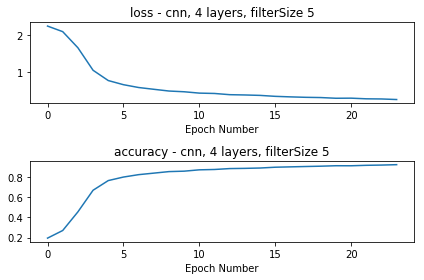

test accuracy:
0.8217962507682852
confusion matrix:


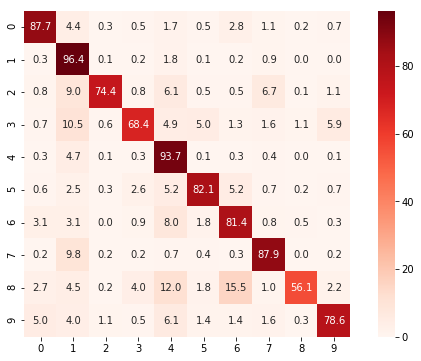

In [103]:
class CNN_Net_4L_K5(nn.Module):
    def __init__(self):
        super(CNN_Net_4L_K5, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn45 = CNN_Net_4L_K5()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn45.parameters(), lr=0.01)
acc_45_cnn = []
loss_45_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn45(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_45_cnn.append(r_loss / 100)
            acc_45_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 4 layers, 5x5 filters')
print('final train accuracy :')
print(acc_45_cnn[len(acc_45_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_45_cnn)
axs[0].set_title('loss - cnn, 4 layers, filterSize 5')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_45_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 4 layers, filterSize 5')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn45(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.280 acc: 0.176
[epoch : 2, itr   100] loss: 2.240 acc: 0.188
[epoch : 3, itr   100] loss: 2.235 acc: 0.190
[epoch : 4, itr   100] loss: 2.228 acc: 0.191
[epoch : 5, itr   100] loss: 2.210 acc: 0.210
[epoch : 6, itr   100] loss: 2.162 acc: 0.231
[epoch : 7, itr   100] loss: 1.989 acc: 0.300
[epoch : 8, itr   100] loss: 1.755 acc: 0.410
[epoch : 9, itr   100] loss: 1.449 acc: 0.521
[epoch : 10, itr   100] loss: 1.160 acc: 0.624
[epoch : 11, itr   100] loss: 0.977 acc: 0.692
[epoch : 12, itr   100] loss: 0.861 acc: 0.736
[epoch : 13, itr   100] loss: 0.740 acc: 0.777
[epoch : 14, itr   100] loss: 0.663 acc: 0.799
[epoch : 15, itr   100] loss: 0.642 acc: 0.809
[epoch : 16, itr   100] loss: 0.580 acc: 0.825
[epoch : 17, itr   100] loss: 0.557 acc: 0.833
[epoch : 18, itr   100] loss: 0.533 acc: 0.842
[epoch : 19, itr   100] loss: 0.495 acc: 0.852
[epoch : 20, itr   100] loss: 0.489 acc: 0.855
[epoch : 21, itr   100] loss: 0.469 acc: 0.861
[epoch : 22, itr   100

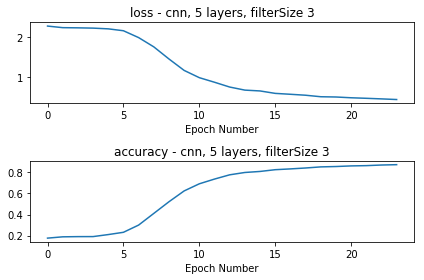

test accuracy:
0.8305931161647203
confusion matrix:


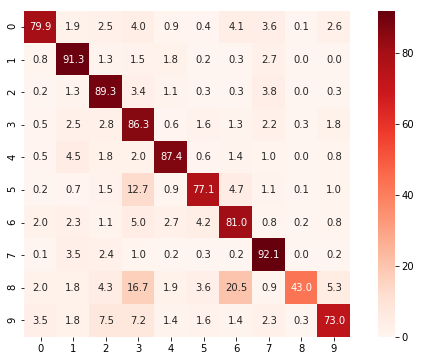

In [59]:
class CNN_Net_5L_K3(nn.Module):
    def __init__(self):
        super(CNN_Net_5L_K3, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.fc1 = nn.Linear(128 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = (F.relu(self.conv5(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn53 = CNN_Net_5L_K3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn53.parameters(), lr=0.01)
acc_53_cnn = []
loss_53_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn53(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_53_cnn.append(r_loss / 100)
            acc_53_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')


print('CNN 5 layers, 3x3 filters')
print('final train accuracy :')
print(acc_53_cnn[len(acc_53_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_53_cnn)
axs[0].set_title('loss - cnn, 5 layers, filterSize 3')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_53_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 5 layers, filterSize 3')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn53(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.248 acc: 0.186
[epoch : 2, itr   100] loss: 2.235 acc: 0.190
[epoch : 3, itr   100] loss: 2.229 acc: 0.190
[epoch : 4, itr   100] loss: 2.197 acc: 0.205
[epoch : 5, itr   100] loss: 2.063 acc: 0.271
[epoch : 6, itr   100] loss: 1.842 acc: 0.373
[epoch : 7, itr   100] loss: 1.469 acc: 0.514
[epoch : 8, itr   100] loss: 1.114 acc: 0.643
[epoch : 9, itr   100] loss: 0.884 acc: 0.722
[epoch : 10, itr   100] loss: 0.772 acc: 0.763
[epoch : 11, itr   100] loss: 0.678 acc: 0.793
[epoch : 12, itr   100] loss: 0.622 acc: 0.811
[epoch : 13, itr   100] loss: 0.559 acc: 0.831
[epoch : 14, itr   100] loss: 0.599 acc: 0.822
[epoch : 15, itr   100] loss: 0.489 acc: 0.856
[epoch : 16, itr   100] loss: 0.471 acc: 0.859
[epoch : 17, itr   100] loss: 0.441 acc: 0.868
[epoch : 18, itr   100] loss: 0.420 acc: 0.876
[epoch : 19, itr   100] loss: 0.400 acc: 0.881
[epoch : 20, itr   100] loss: 0.384 acc: 0.887
[epoch : 21, itr   100] loss: 0.372 acc: 0.891
[epoch : 22, itr   100

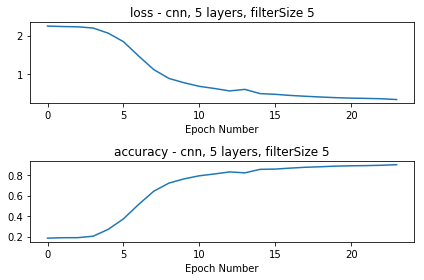

test accuracy:
0.8316687154271666
confusion matrix:


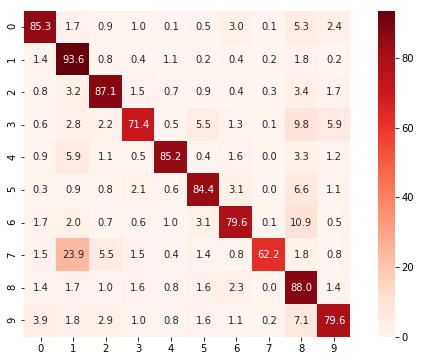

In [61]:
class CNN_Net_5L_K5(nn.Module):
    def __init__(self):
        super(CNN_Net_5L_K5, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2, stride=1)
        self.conv5 = nn.Conv2d(64, 128, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(128 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn55 = CNN_Net_5L_K5()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn55.parameters(), lr=0.01)
acc_55_cnn = []
loss_55_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn55(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_55_cnn.append(r_loss / 100)
            acc_55_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 5 layers, 5x5 filters')
print('final train accuracy :')
print(acc_55_cnn[len(acc_55_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_55_cnn)
axs[0].set_title('loss - cnn, 5 layers, filterSize 5')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_55_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 5 layers, filterSize 5')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn55(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.290 acc: 0.175
[epoch : 2, itr   100] loss: 2.242 acc: 0.189
[epoch : 3, itr   100] loss: 2.239 acc: 0.189
[epoch : 4, itr   100] loss: 2.238 acc: 0.188
[epoch : 5, itr   100] loss: 2.234 acc: 0.188
[epoch : 6, itr   100] loss: 2.226 acc: 0.192
[epoch : 7, itr   100] loss: 2.214 acc: 0.199
[epoch : 8, itr   100] loss: 2.196 acc: 0.206
[epoch : 9, itr   100] loss: 2.137 acc: 0.231
[epoch : 10, itr   100] loss: 2.004 acc: 0.279
[epoch : 11, itr   100] loss: 1.843 acc: 0.354
[epoch : 12, itr   100] loss: 1.613 acc: 0.456
[epoch : 13, itr   100] loss: 1.309 acc: 0.570
[epoch : 14, itr   100] loss: 1.076 acc: 0.655
[epoch : 15, itr   100] loss: 0.906 acc: 0.717
[epoch : 16, itr   100] loss: 0.772 acc: 0.763
[epoch : 17, itr   100] loss: 0.715 acc: 0.781
[epoch : 18, itr   100] loss: 0.657 acc: 0.802
[epoch : 19, itr   100] loss: 0.613 acc: 0.816
[epoch : 20, itr   100] loss: 0.583 acc: 0.824
[epoch : 21, itr   100] loss: 0.562 acc: 0.831
[epoch : 22, itr   100

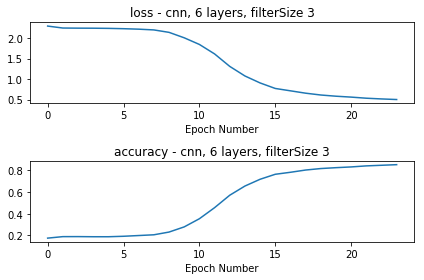

test accuracy:
0.7539950829748002
confusion matrix:


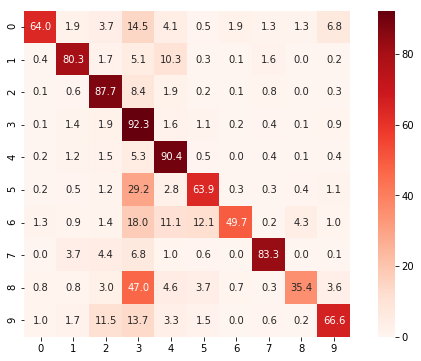

In [63]:
class CNN_Net_6L_K3(nn.Module):
    def __init__(self):
        super(CNN_Net_6L_K3, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1, stride=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = (F.relu(self.conv5(x)))
        x = (F.relu(self.conv6(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn63 = CNN_Net_6L_K3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn63.parameters(), lr=0.01)
acc_63_cnn = []
loss_63_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn63(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_63_cnn.append(r_loss / 100)
            acc_63_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')


print('CNN 6 layers, 3x3 filters')
print('final train accuracy :')
print(acc_63_cnn[len(acc_63_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_63_cnn)
axs[0].set_title('loss - cnn, 6 layers, filterSize 3')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_63_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 6 layers, filterSize 3')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn63(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.299 acc: 0.134
[epoch : 2, itr   100] loss: 2.273 acc: 0.189
[epoch : 3, itr   100] loss: 2.242 acc: 0.189
[epoch : 4, itr   100] loss: 2.237 acc: 0.192
[epoch : 5, itr   100] loss: 2.235 acc: 0.191
[epoch : 6, itr   100] loss: 2.235 acc: 0.190
[epoch : 7, itr   100] loss: 2.233 acc: 0.190
[epoch : 8, itr   100] loss: 2.225 acc: 0.190
[epoch : 9, itr   100] loss: 2.200 acc: 0.208
[epoch : 10, itr   100] loss: 2.101 acc: 0.254
[epoch : 11, itr   100] loss: 2.012 acc: 0.275
[epoch : 12, itr   100] loss: 1.950 acc: 0.305
[epoch : 13, itr   100] loss: 1.809 acc: 0.373
[epoch : 14, itr   100] loss: 1.504 acc: 0.488
[epoch : 15, itr   100] loss: 1.211 acc: 0.594
[epoch : 16, itr   100] loss: 1.025 acc: 0.669
[epoch : 17, itr   100] loss: 0.892 acc: 0.717
[epoch : 18, itr   100] loss: 0.812 acc: 0.747
[epoch : 19, itr   100] loss: 0.719 acc: 0.777
[epoch : 20, itr   100] loss: 0.661 acc: 0.798
[epoch : 21, itr   100] loss: 0.599 acc: 0.818
[epoch : 22, itr   100

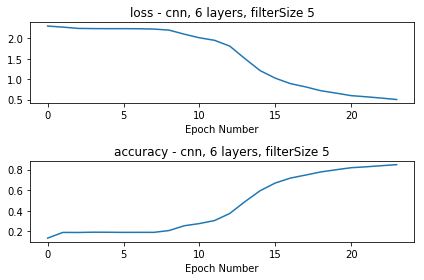

test accuracy:
0.780539336201598
confusion matrix:


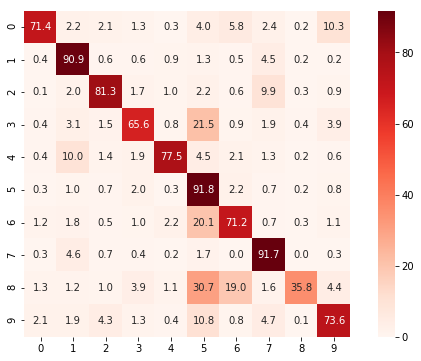

In [64]:
class CNN_Net_6L_K5(nn.Module):
    def __init__(self):
        super(CNN_Net_6L_K5, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2, stride=1)
        self.conv5 = nn.Conv2d(64, 128, 5, padding=2, stride=1)
        self.conv6 = nn.Conv2d(128, 256, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn65 = CNN_Net_6L_K5()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn65.parameters(), lr=0.01)
acc_65_cnn = []
loss_65_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn65(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_65_cnn.append(r_loss / 100)
            acc_65_cnn.append(train_acc / 100)
            running_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 6 layers, 5x5 filters')
print('final train accuracy :')
print(acc_65_cnn[len(acc_65_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_65_cnn)
axs[0].set_title('loss - cnn, 6 layers, filterSize 5')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_65_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 6 layers, filterSize 5')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn65(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

# TEST DROPOUT

[epoch : 1, itr   100] loss: 2.258 acc: 0.179
[epoch : 2, itr   100] loss: 2.243 acc: 0.190
[epoch : 3, itr   100] loss: 2.238 acc: 0.189
[epoch : 4, itr   100] loss: 2.219 acc: 0.201
[epoch : 5, itr   100] loss: 2.173 acc: 0.224
[epoch : 6, itr   100] loss: 2.023 acc: 0.297
[epoch : 7, itr   100] loss: 1.731 acc: 0.413
[epoch : 8, itr   100] loss: 1.461 acc: 0.519
[epoch : 9, itr   100] loss: 1.272 acc: 0.590
[epoch : 10, itr   100] loss: 1.149 acc: 0.640
[epoch : 11, itr   100] loss: 1.032 acc: 0.683
[epoch : 12, itr   100] loss: 0.970 acc: 0.705
[epoch : 13, itr   100] loss: 0.912 acc: 0.723
[epoch : 14, itr   100] loss: 0.873 acc: 0.736
[epoch : 15, itr   100] loss: 0.840 acc: 0.746
[epoch : 16, itr   100] loss: 0.812 acc: 0.756
[epoch : 17, itr   100] loss: 0.781 acc: 0.764
[epoch : 18, itr   100] loss: 0.751 acc: 0.775
[epoch : 19, itr   100] loss: 0.728 acc: 0.782
[epoch : 20, itr   100] loss: 0.706 acc: 0.788
[epoch : 21, itr   100] loss: 0.693 acc: 0.794
[epoch : 22, itr   100

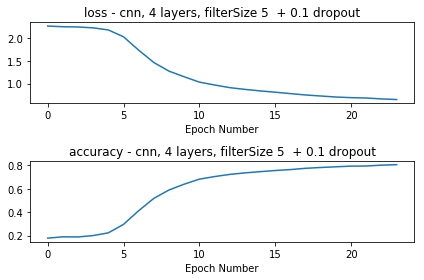

test accuracy:
0.7277581438229871
confusion matrix:


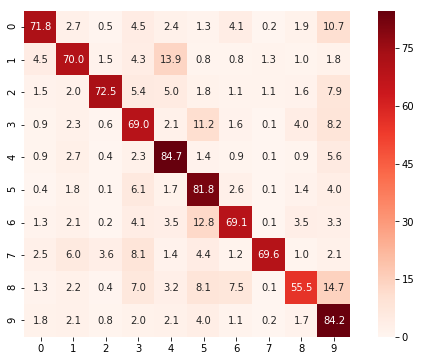

In [90]:
#drop out 0.3
class CNN_Net_4L_K5_d1(nn.Module):
    def __init__(self):
        super(CNN_Net_4L_K5_d1, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.dropout2d(self.pool(F.relu(self.conv1(x))))
        x = F.dropout2d(self.pool(F.relu(self.conv2(x))), 0.1)
        x = F.dropout2d(self.pool(F.relu(self.conv3(x))), 0.1)
        x = F.dropout2d(self.pool(F.relu(self.conv4(x))), 0.1)
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn451 = CNN_Net_4L_K5_d1()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn451.parameters(), lr=0.01)
acc_451_cnn = []
loss_451_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn451(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_451_cnn.append(r_loss / 100)
            acc_451_cnn.append(train_acc / 100)
            r_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 4 layers, 5x5 filters + 0.1 dropout')
print('final train accuracy :')
print(acc_451_cnn[len(acc_451_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_451_cnn)
axs[0].set_title('loss - cnn, 4 layers, filterSize 5  + 0.1 dropout')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_451_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 4 layers, filterSize 5  + 0.1 dropout')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn451(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

[epoch : 1, itr   100] loss: 2.265 acc: 0.177
[epoch : 2, itr   100] loss: 2.246 acc: 0.188
[epoch : 3, itr   100] loss: 2.240 acc: 0.187
[epoch : 4, itr   100] loss: 2.224 acc: 0.197
[epoch : 5, itr   100] loss: 2.174 acc: 0.224
[epoch : 6, itr   100] loss: 2.092 acc: 0.263
[epoch : 7, itr   100] loss: 1.948 acc: 0.329
[epoch : 8, itr   100] loss: 1.710 acc: 0.419
[epoch : 9, itr   100] loss: 1.474 acc: 0.508
[epoch : 10, itr   100] loss: 1.316 acc: 0.569
[epoch : 11, itr   100] loss: 1.195 acc: 0.618
[epoch : 12, itr   100] loss: 1.112 acc: 0.651
[epoch : 13, itr   100] loss: 1.052 acc: 0.678
[epoch : 14, itr   100] loss: 1.002 acc: 0.695
[epoch : 15, itr   100] loss: 0.949 acc: 0.710
[epoch : 16, itr   100] loss: 0.920 acc: 0.720
[epoch : 17, itr   100] loss: 0.895 acc: 0.732
[epoch : 18, itr   100] loss: 0.870 acc: 0.740
[epoch : 19, itr   100] loss: 0.837 acc: 0.749
[epoch : 20, itr   100] loss: 0.815 acc: 0.759
[epoch : 21, itr   100] loss: 0.793 acc: 0.765
[epoch : 22, itr   100

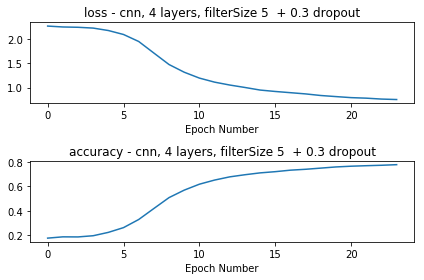

test accuracy:
0.7351336816226183
confusion matrix:


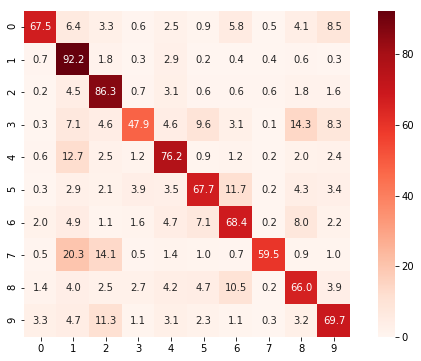

In [89]:
#drop out 0.3
class CNN_Net_4L_K5_d3(nn.Module):
    def __init__(self):
        super(CNN_Net_4L_K5_d3, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2, stride=1)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=2, stride=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.dropout2d(self.pool(F.relu(self.conv1(x))), p=0.3)
        x = F.dropout2d(self.pool(F.relu(self.conv2(x))), 0.3)
        x = F.dropout2d(self.pool(F.relu(self.conv3(x))), 0.3)
        x = F.dropout2d(self.pool(F.relu(self.conv4(x))), 0.3)
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn453 = CNN_Net_4L_K5_d3()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn453.parameters(), lr=0.01)
acc_453_cnn = []
loss_453_cnn = []
for epoch in range(24):  
    train_acc = 0.0
    r_loss = 0.0
    for i, train_data in enumerate(train_loader, 0):
        inputs, labels = train_data
        
        optimizer.zero_grad()
        
        outputs = cnn453(inputs)
        
        _, pred = torch.max(outputs, dim = 1)
        equals = pred == labels
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        r_loss += loss.item()
        
        if i % 100 == 99:    
            print('[epoch : %d, itr %5d] loss: %.3f acc: %.3f'  % (epoch + 1, i + 1, r_loss / 100, train_acc / 100))
            loss_453_cnn.append(r_loss / 100)
            acc_453_cnn.append(train_acc / 100)
            r_loss = 0.0
            train_acc = 0.0

print('Model Trained')

print('CNN 4 layers, 5x5 filters + 0.3 dropout')
print('final train accuracy :')
print(acc_453_cnn[len(acc_453_cnn)-1])
fig, axs = plt.subplots(2, 1)
axs[0].plot(loss_453_cnn)
axs[0].set_title('loss - cnn, 4 layers, filterSize 5  + 0.3 dropout')
axs[0].set(xlabel='Epoch Number')
axs[1].plot(acc_453_cnn)
axs[1].set(xlabel='Epoch Number')
axs[1].set_title('accuracy - cnn, 4 layers, filterSize 5  + 0.3 dropout')
fig.tight_layout()
plt.show()
print('test accuracy:')
y_pred = []
for sample in X_test:
    y_pred.append(np.argmax(cnn453(torch.Tensor(sample).float().unsqueeze(0)).detach().numpy()))
ypred = np.array(y_pred)
print(np.mean(y_pred == y_test))
print('confusion matrix:')
plt.figure(figsize=(10, 6))
cmat = confusion_matrix(y_true=y_test, y_pred=ypred)
cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cmat, annot=True, cmap='Reds', fmt='.1f', square=True);

## Q 4

In [102]:
fc2_acc = []
fc2_loss = []
class FC2(nn.Module):
    
    def __init__(self):
        super(FC2, self).__init__()
        self.l1 = nn.Linear(32 * 32 * 3, 200)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = F.dropout(self.l1(x), 0.1)
        x = self.relu(x)
        x =  F.dropout(self.l3(x), 0.1)
        return F.log_softmax(x, dim=1)
    
fc2 = FC2()

optimizer = optim.SGD(fc2.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
loss_log = []

for e in range(24):
    for i in range(0, n_train, 512):
        x_b = X_train_tesnor[i:i + 512] 
        y_b = y_train_tensor[i:i + 512] 
        x_v = Variable(x_b)
        y_v = Variable(y_b)
        optimizer.zero_grad()
        out = fc2(x_v)
        loss = loss_func(out, y_v)
        _, pred = torch.max(out, dim = 1)
        equals = pred == y_v
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        r_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print('[epoch : %d] loss: %.3f acc: %.3f'  % (e + 1,  r_loss / 100, train_acc / 100))
    fc2_loss.append(r_loss / 100)
    fc2_acc.append(train_acc / 100)
    r_loss = 0.0
    train_acc = 0.0

[epoch : 1] loss: 6629.544 acc: 0.322
[epoch : 2] loss: 3.275 acc: 0.265
[epoch : 3] loss: 3.261 acc: 0.264
[epoch : 4] loss: 3.251 acc: 0.265
[epoch : 5] loss: 3.245 acc: 0.266
[epoch : 6] loss: 3.240 acc: 0.266
[epoch : 7] loss: 3.237 acc: 0.264
[epoch : 8] loss: 3.234 acc: 0.267
[epoch : 9] loss: 3.233 acc: 0.265
[epoch : 10] loss: 3.231 acc: 0.267
[epoch : 11] loss: 3.236 acc: 0.268
[epoch : 12] loss: 3.232 acc: 0.264
[epoch : 13] loss: 3.231 acc: 0.265
[epoch : 14] loss: 3.230 acc: 0.266
[epoch : 15] loss: 3.231 acc: 0.265
[epoch : 16] loss: 3.231 acc: 0.265
[epoch : 17] loss: 3.230 acc: 0.265
[epoch : 18] loss: 3.230 acc: 0.265
[epoch : 19] loss: 3.230 acc: 0.267
[epoch : 20] loss: 3.230 acc: 0.265
[epoch : 21] loss: 3.230 acc: 0.265
[epoch : 22] loss: 3.229 acc: 0.266
[epoch : 23] loss: 3.230 acc: 0.265
[epoch : 24] loss: 3.229 acc: 0.266


## T

filters :


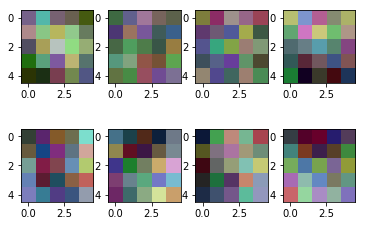

feature maps :


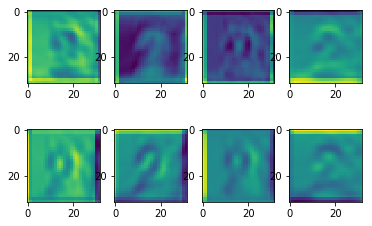

In [128]:
conv1 = cnn45.conv1
filt = conv1.weight.data.numpy().transpose([0, 2, 3, 1])
filt = (filt -  np.min(filt)) * 2
fig, ax = plt.subplots(2, 4)
print('filters :')
for idx in range(8):
    ax[idx%2, int(idx/2)].imshow(filt[idx])
plt.show()
fm = {}
def get_fm(name):
    def hook(model, input, output):
        fm[name] = output.detach()
    return hook

cnn45.conv1.register_forward_hook(get_fm('conv1'))
data, _ = test_dataset[1]
data.unsqueeze_(0)
output = cnn45(data)
print('feature maps :')
act = fm['conv1'].squeeze()
fig, axarr = plt.subplots(2, 4)
for idx in range(act.size(0)):
    axarr[idx%2, int(idx/2)].imshow(act[idx])
plt.show()

## TH

In [139]:
import tensorflow as tf

def give_me_boxes(img):
    i = 0
    j = -1
    k = 0
    score = []
    number = []
    for r in range(100):
        i = i + 0.5
        j = j + 1
        width = int(img.shape[1] / (1.2)**j)
        height = int(img.shape[0] / (1.2)**j)
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        if resized.shape[0] < 32 or resized.shape[1] < 32:
            break
        for y in range(0, resized.shape[0] - 31, int(8/i)):
            for x in range(0, resized.shape[1] - 31, int(8/i)):
                window = resized[y:y+32, x:x+32, :]
                out = cnn45(torch.Tensor(window.transpose([2,0,1])).float().unsqueeze(0)).detach().numpy()
                label = np.argmax(out)
                p = out[0][label]
                if p >  5:
                    score.append(p)
                    number.append(label)
                    x2 = int(x * (1.2**j))
                    y2 = int(y * (1.2**j))
                    w = int(47 * (1.2**j))
                    h = int(62 * (1.2**j))
                    if k == 0:
                        k = k + 1
                        boxes = np.array([[y2, x2, y2+h, x2+w]]).T
                    else:
                        boxes = np.concatenate((boxes, np.array([[y2, x2, y2+h, x2+w]]).T)
                                               , axis=1)
    return boxes, score, number


def my_final_box(boxes, score, img6, color):
    img = img6.copy()
    img1 = img.copy()
    my_boxes = boxes.T
    scores = np.array([s for s in score])
    thresh_score = 5
    my_boxes = my_boxes[scores > thresh_score]
    scores = scores[scores > thresh_score]
    selected_indices = tf.image.non_max_suppression(
        my_boxes, scores, 1, 0.8)
    selected_boxes = tf.gather(my_boxes, selected_indices)
    config = tf.ConfigProto(
            device_count={'GPU': 0}
        )
    with tf.Session(config=config) as sess:
        nmsbox = (selected_boxes.eval())
        cv2.rectangle(img, (nmsbox[0, 1], nmsbox[0, 0]), (nmsbox[0, 3], nmsbox[0, 2]), color, 5)
    heatMap = np.zeros((img.shape[0], img.shape[1])).astype('uint8')
    for (x, y, w, h) in my_boxes:
        heatMap[x:w, y:h] = cv2.add(heatMap[x:w, y:h], 20)
    max_b = np.max(np.max(heatMap))
    heatMap[heatMap < int(max_b)] = 0
    (Y, X) = np.nonzero(heatMap)
    w, h = min(X), min(Y)
    x, y = max(X), max(Y)
    cv2.rectangle(img1, (x, y), (w, h), color, 2)
    return img, img1

In [ ]:
from skimage.transform.pyramids import pyramid_gaussian
img = cv2.imread('46.png')
cv2.imshow('1', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
(boxes, score, number) = give_me_boxes(img)


def show_and_write(nmx, hm, num):
    cv2.imshow('test_image ' + str(num) + ' : Non max suppression', nmx)
    cv2.waitKey(0)
    

for i in range(10) :
    n_arr = np.array(number)
    s_arr = np.array(score)
    b_arr = np.array(boxes)
    idx = np.where(n_arr == i)[0]
    if (len(idx) > 0):
        vals = np.max(s_arr[idx])
        if (vals > 20) :
            print(vals)
            print(i)
            nmx, hm = my_final_box(b_arr[:,idx], s_arr[idx], img, (0, 0, 50*(i+1)))
            show_and_write(nmx, hm, i)

cv2.destroyAllWindows()

23.066683
2
